# Лабораторна робота №4: Моделі класифікації та їх оцінка

### Мета роботи

Ознайомитися з основними моделями класифікації, а також навчитися оцінювати якість класифікаторів за різноманітними метриками.

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder

### 1. Завантаження даних

Завантажте набори даних "Airline Passenger Satisfaction" для навчання (`train.csv`) та тестування (`test.csv`)  з [Kaggle](https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction) або з Google Classroom.

In [53]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


### 2. Обробка набору даних

1. З набору даних видаліть наступні стовпці:
    * `"Unnamed: 0"`
    * `"id"`
2. Заповніть всі пусті значення у наборі даних значенням `0`.
3. Перетворіть стовпці рядкових значень на стовпці, що мають числові значення.
4. Нормалізуйте значення кожної ознаки моделі з набору даних для навчання.

_У наборі даних кожен зі стовпчиків є ознакою моделі, окрім останнього під назвою `"satisfaction"`, який є цільовою змінною._

In [54]:
# Видаляємо непотрібвні стовпці "Unnamed: 0" та "id"
cols_to_drop = ['Unnamed: 0', 'id']
train = train.drop(columns=cols_to_drop)
test = test.drop(columns=cols_to_drop)

# Заповнюємо пропущені значення (NaN) значенням 0
train = train.fillna(0)
test = test.fillna(0)

# Виділяємо цільову змінну та ознаки
target = 'satisfaction'
X_train = train.drop(target, axis=1)
y_train = train[target]
X_test = test.drop(target, axis=1)
y_test = test[target]

# Перетворення категоріальних ознак у числові за допоамогою one-hot encoding.
# Для цього застосовуємо pd.get_dummies до всіх стовпців, окрім цільового.
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
# Забезпечуємо однаковий набір ознак у навчальній та тестовій вибірках
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

# Перетворення цільової змінної у числовий формат
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Нормалізація ознак
scaler = StandardScaler()   # z = (x - mean) / std
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)

### 3. Навчання моделей

Натренуйте кожну з моделей:

* Наївний баєсів класифікатор [Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
* Дерево рішень [Decision Tree](https://scikit-learn.org/stable/modules/tree.html)
* Логістична регресія [Logistic Regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)
* K-найближчі сусідів [K-Nearest Neighbors](https://scikit-learn.org/stable/modules/neighbors.html)
* Випадковий ліс [Random Forest](https://scikit-learn.org/stable/modules/ensemble.html#random-forests-and-other-randomized-tree-ensembles)

_Для кожної з моделей також підрахуйте час виконання у мілісекундах, це буде необхідно для виконання 4-го завдання._

In [55]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import multiprocessing
import time

def train_model(model_tuple):
    name, model = model_tuple
    start = time.time()
    model.fit(X_train_scaled, y_train)  
    end = time.time()
    training_time = (end - start) * 1000  # переведення часу в мілісекунди
    return name, model, training_time


# Створення списку моделей
models_list = [
    ("Naive Bayes", GaussianNB()),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Logistic Regression", LogisticRegression(max_iter=1000, random_state=42)),
    ("K-NN", KNeighborsClassifier()),
    ("Random Forest", RandomForestClassifier(random_state=42))
]

pool = multiprocessing.Pool(processes=len(models_list))
results = pool.map(train_model, models_list)
pool.close()
pool.join()

# Збереження моделей та часу навчання у словники
models = {}
training_times = {}
for name, model, t_time in results:
    models[name] = model
    training_times[name] = t_time

# Вивід часу навчання для кожної моделі (в мілісекундах)
print("Часи навчання (в мілісекундах):")
print(training_times)

Часи навчання (в мілісекундах):
{'Naive Bayes': 74.93710517883301, 'Decision Tree': 1358.2069873809814, 'Logistic Regression': 632.432222366333, 'K-NN': 32.03988075256348, 'Random Forest': 13782.07516670227}


### 4. Підрахунок основних метрик

Для кожної з моделей підрахуйте наступні метрики:

* [Accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
* [Precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)
* [Recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)
* [F1-Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
* Швидкість виконання (у мс.)

Отримані дані запишіть у `DataFrame` та візуалізуйте його у вигляді таблиці. Також можете додати до `DataFrame` `.style.background_gradient(cmap='Greens')`, що дозволить краще візуально порівнювати значення у кожному зі стовпчиків.

In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

model_names = []
accuracies = []
precisions = []
recalls = []
f1_scores = []
times_list = []

# для кожної моделі проводимо передбfчення та обчислюємо метрики
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    model_names.append(name)
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    times_list.append(training_times[name])

metrics_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores,
    'Training Time (ms)': times_list
})

print(metrics_df)
display(metrics_df.style.background_gradient())

                 Model  Accuracy  Precision    Recall  F1 Score  \
0          Naive Bayes  0.857137   0.855913  0.811102  0.832906   
1        Decision Tree  0.946220   0.935650  0.942296  0.938961   
2  Logistic Regression  0.871612   0.868941  0.833202  0.850696   
3                 K-NN  0.927702   0.948151  0.883627  0.914753   
4        Random Forest  0.962696   0.972983  0.941156  0.956805   

   Training Time (ms)  
0           74.937105  
1         1358.206987  
2          632.432222  
3           32.039881  
4        13782.075167  


,Model,Accuracy,Precision,Recall,F1 Score,Training Time (ms)
0,Naive Bayes,0.857137,0.855913,0.811102,0.832906,74.937105
1,Decision Tree,0.946220,0.935650,0.942296,0.938961,1358.206987
2,Logistic Regression,0.871612,0.868941,0.833202,0.850696,632.432222
3,K-NN,0.927702,0.948151,0.883627,0.914753,32.039881
4,Random Forest,0.962696,0.972983,0.941156,0.956805,13782.075167


### 5. Візуалізація матриць невідповідностей

Для кожної з моделей візуалізуйте [матрицю невідповідності](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

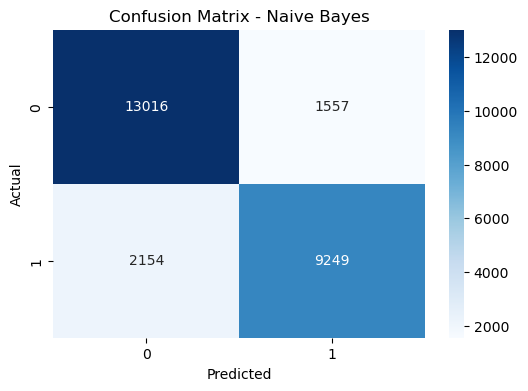

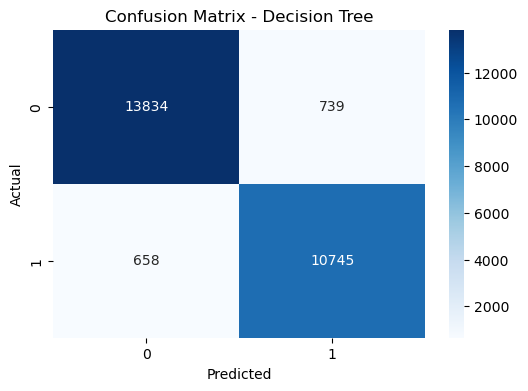

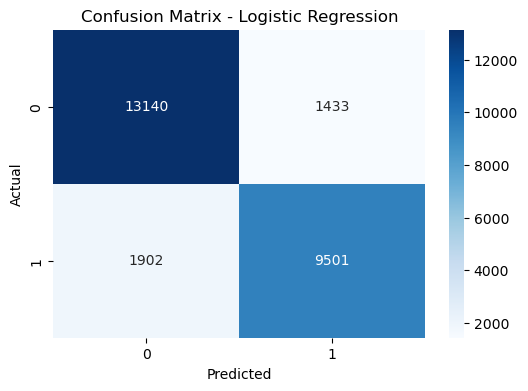

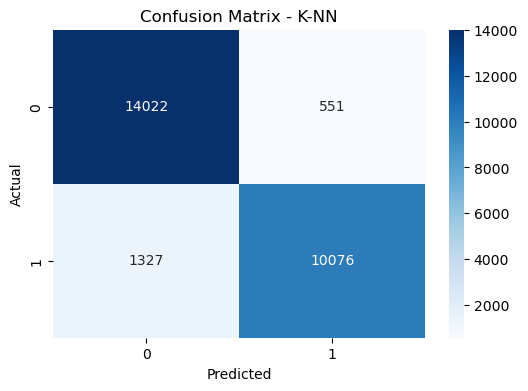

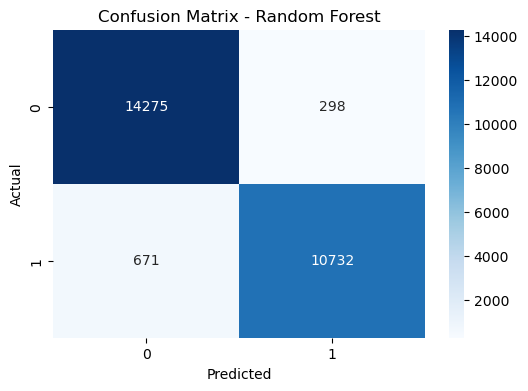

In [57]:
def plot_conf_matrix(model, X, y, title):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

for name, model in models.items():
    plot_conf_matrix(model, X_test_scaled, y_test, name)

### Додаткове завдання: Модель XGBoost (XGBClassifier) як альтернативний підхід для класифікації.

In [58]:
import xgboost as xgb
import time

xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

start = time.time()
xgb_model.fit(X_train_scaled, y_train) 
end = time.time()

xgb_training_time = (end - start) * 1000
print("Час навчання XGBoost (в мілісекундах):", xgb_training_time)

/home/yaroslav/study/uni/8-sem/MIS/.conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:10:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1744352472081/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Час навчання XGBoost (в мілісекундах): 543.1599617004395


In [59]:
y_pred = xgb_model.predict(X_test_scaled)

model_names.append("XGBoost")
accuracies.append(accuracy_score(y_test, y_pred))
precisions.append(precision_score(y_test, y_pred))
recalls.append(recall_score(y_test, y_pred))
f1_scores.append(f1_score(y_test, y_pred))
times_list.append(xgb_training_time)

metrics_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores,
    'Training Time (ms)': times_list
})

# виводимо отриманий DataFrame
print(metrics_df)
display(metrics_df.style.background_gradient())

                 Model  Accuracy  Precision    Recall  F1 Score  \
0          Naive Bayes  0.857137   0.855913  0.811102  0.832906   
1        Decision Tree  0.946220   0.935650  0.942296  0.938961   
2  Logistic Regression  0.871612   0.868941  0.833202  0.850696   
3                 K-NN  0.927702   0.948151  0.883627  0.914753   
4        Random Forest  0.962696   0.972983  0.941156  0.956805   
5              XGBoost  0.963505   0.971158  0.944927  0.957863   

   Training Time (ms)  
0           74.937105  
1         1358.206987  
2          632.432222  
3           32.039881  
4        13782.075167  
5          543.159962  


,Model,Accuracy,Precision,Recall,F1 Score,Training Time (ms)
0,Naive Bayes,0.857137,0.855913,0.811102,0.832906,74.937105
1,Decision Tree,0.946220,0.935650,0.942296,0.938961,1358.206987
2,Logistic Regression,0.871612,0.868941,0.833202,0.850696,632.432222
3,K-NN,0.927702,0.948151,0.883627,0.914753,32.039881
4,Random Forest,0.962696,0.972983,0.941156,0.956805,13782.075167
5,XGBoost,0.963505,0.971158,0.944927,0.957863,543.159962
